# Introduction

This repository is part of the final assignment for Explainable AI from Joanne Held, s1049387.

For this project, we will be looking to implement an Integrated Gradients (IG) and Layer-wise Relevance Propagation (LRP) explanation within a Transformer model for Time series trained on financial time series data.

Specifically we are going to look at stock price predictions for the next day's 'Open' price based on historical data for two tickers with daily data for a significant time period.It will be explained in more detail later on when discussing the data and where we get it from.

Afterwards we evaluate the quality and faithfullness of the differing explanations each method provides.


# Installs

For running on any device, make sure to install the below pip commands, which will be used throughout the project. Any necessary imports are included in the code.

In [90]:
!pip install yfinance torch torchvision torchaudio captum scikit-learn seaborn matplotlib

# Dataset and preprocessing

We will be looking at 2 tickers, AAPL and TSLA. We will be looking at data from Yahoo Finance, with timeframes between 1-1-2015 and 31-12-2024 to get as broad a timeframe as we can get with reliable data for both tickers. This time frame will be enough to train our model on which we can later try to explain. We expect a few thousand data points, around 2500 rows with 5 columns per ticker.

We want to give our model daily data and 5 metrics within it: Close, High, Low, Open, Volume.

Below we download the data we will be needed to train our models.

In [91]:
# make necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import yfinance as yf

# create 2 dataframes, for AAPL ticker and TSLA ticker
df_AAPL = yf.download("AAPL", start="2015-01-01", end="2024-12-31")
df_TSLA = yf.download("TSLA", start="2015-01-01", end="2024-12-31")

# print the heads of the dataframes for inspection
print("\n\nWe look at the head of the dataframes we created for AAPL and TSLA,\nthis indeed has all the data we look for.\n")
print(df_AAPL.head())
print(df_AAPL.shape)
print ("\n")
print(df_TSLA.head())
print(df_TSLA.shape)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



We look at the head of the dataframes we created for AAPL and TSLA,
this indeed has all the data we look for.

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.320433  24.789802  23.879981  24.778679  212818400
2015-01-05  23.635286  24.169166  23.448429  24.089084  257142000
2015-01-06  23.637510  23.897776  23.274916  23.699796  263188400
2015-01-07  23.968958  24.069060  23.735385  23.846610  160423600
2015-01-08  24.889908  24.947745  24.180292  24.298192  237458000
(2515, 5)


Price           Close       High        Low       Open    Volume
Ticker           TSLA       TSLA       TSLA       TSLA      TSLA
Date                                                            
2015-01-02  14.620667  14.883333  14.217333  14.858000  71466000
2015-01-05  14.006000  14.433333  13.810667  14.303333  80527500
2015-01-06  14.085333 

Now we normalize the data. We normalize each ticker separately on all numerical values.

In [92]:
# columns to use for the model
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# normalize and store scalers to inverse later
def normalize_stock_df(df):
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])
    return df_scaled, scaler

df_AAPL_scaled, scaler_AAPL = normalize_stock_df(df_AAPL)
df_TSLA_scaled, scaler_TSLA = normalize_stock_df(df_TSLA)

Then we create the input and output sequences, this will be necessary to use a certain amount of historical data to predict the next day's Open price. Now we separate our datasets into sequences of 30 days each, which means a prediction for the next days open price will always be taking only the 30 days before it into consideration.

In [93]:
def create_sequences(data, input_len=30, target_col='Open'):
    sequences = []
    targets = []
    data_array = data[feature_cols].values
    target_idx = feature_cols.index(target_col)

    for i in range(len(data_array) - input_len):
        seq = data_array[i:i+input_len]
        target = data_array[i+input_len, target_idx]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

# create our 30 day sequences from the scaled datasets
aapl_seq, aapl_targets = create_sequences(df_AAPL_scaled)
tsla_seq, tsla_targets = create_sequences(df_TSLA_scaled)

Then, the last thing we need for our Transformer is to define a dataset and create a data loader. We define a class for this, to keep it modular for ourselves, which is always good practice. We define the batch size as 32, which means that each training step will use 32 sequences of 30 days.

Note! The shuffle parameter only shuffles the order of the sequences around, but this does not affect the temporal order inside the sequences, that we defined previously. This order is important because we want our transformer model to look at patterns in a time series.

In [94]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# create datasets
aapl_dataset = TimeSeriesDataset(aapl_seq, aapl_targets)
tsla_dataset = TimeSeriesDataset(tsla_seq, tsla_targets)

# dataloaders (we can change batch size later if necessary)
aapl_loader = DataLoader(aapl_dataset, batch_size=32, shuffle=True)
tsla_loader = DataLoader(tsla_dataset, batch_size=32, shuffle=True)

# Transformer-based model in PyTorch

We will be creating transformer based model that will do our time series forecasting with our previously created dataset. We will optimize for 30 day sequences where each day has 5 features that we sepecified before: Close, High, Low, Open, Volume.

As an output we are only looking for a single value: the next day's Open price. This is our only predicted value. We also want it to include positional encoding. This is neccessary because a transformer does not know the order of inputs by default, so this layer is important.

In [95]:
import torch.nn as nn
import math

# define positional encoding layer class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# define transformertimeseries model class
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim=5, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        # input projection to d_model
        self.input_proj = nn.Linear(input_dim, d_model)

        # positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # output head
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        # src shape: (batch_size, seq_len, input_dim)
        x = self.input_proj(src)                          # (batch, seq, d_model)
        x = self.pos_encoder(x)                           # add positional encodings
        x = self.transformer(x)                           # transformer encoder

        x = x[:, -1, :]                                   # get the last time step’s output
        output = self.fc_out(x).squeeze(-1)               # final forecast
        return output


In [96]:
import torch.optim as optim

"""
# instantiating the models we will be using
model = TransformerTimeSeries()
"""

# set up training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Preparing dataset for training loop

We want to use a basic train/test split function to prepare our data for training our models. We will train a seperate model for each ticker so we will split each dataset separately.

In [97]:
# define function for train/test split
def train_test_split(sequences, targets, test_ratio=0.2):
    split = int(len(sequences) * (1 - test_ratio))
    train_seq = sequences[:split]
    train_targets = targets[:split]
    test_seq = sequences[split:]
    test_targets = targets[split:]
    return train_seq, train_targets, test_seq, test_targets

# AAPL
aapl_train_seq, aapl_train_targets, aapl_test_seq, aapl_test_targets = train_test_split(aapl_seq, aapl_targets)

# TSLA
tsla_train_seq, tsla_train_targets, tsla_test_seq, tsla_test_targets = train_test_split(tsla_seq, tsla_targets)

# helper to wrap everything
def get_dataloader(sequences, targets, batch_size=32):
    dataset = TimeSeriesDataset(sequences, targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# AAPL
aapl_train_loader = get_dataloader(aapl_train_seq, aapl_train_targets)
aapl_test_loader = get_dataloader(aapl_test_seq, aapl_test_targets)

# TSLA
tsla_train_loader = get_dataloader(tsla_train_seq, tsla_train_targets)
tsla_test_loader = get_dataloader(tsla_test_seq, tsla_test_targets)

# Training the model

So now that we have the data in a useable way, we want to train our Time Series Transformer model on this data to start being able to make a prediction.

In [98]:
# define how to a train model in a function
def train_model(model, train_loader, test_loader, num_epochs=20, lr=1e-3, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * X_batch.size(0)

        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # evaluation
        model.eval()
        epoch_test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                epoch_test_loss += loss.item() * X_batch.size(0)
        epoch_test_loss /= len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}")

    return model, train_losses, test_losses

In [76]:
# now we train both models with the function we defined above

# AAPL
model_aapl = TransformerTimeSeries()
model_aapl, aapl_train_losses, aapl_test_losses = train_model(model_aapl, aapl_train_loader, aapl_test_loader)

# TSLA
model_tsla = TransformerTimeSeries()
model_tsla, tsla_train_losses, tsla_test_losses = train_model(model_tsla, tsla_train_loader, tsla_test_loader)

Epoch 1/20 - Train Loss: 0.258941, Test Loss: 0.004715
Epoch 2/20 - Train Loss: 0.006021, Test Loss: 0.005876
Epoch 3/20 - Train Loss: 0.004485, Test Loss: 0.004209
Epoch 4/20 - Train Loss: 0.003489, Test Loss: 0.004240
Epoch 5/20 - Train Loss: 0.002658, Test Loss: 0.004255
Epoch 6/20 - Train Loss: 0.001976, Test Loss: 0.003978
Epoch 7/20 - Train Loss: 0.001686, Test Loss: 0.005018
Epoch 8/20 - Train Loss: 0.001755, Test Loss: 0.003651
Epoch 9/20 - Train Loss: 0.001329, Test Loss: 0.003773
Epoch 10/20 - Train Loss: 0.001126, Test Loss: 0.003202
Epoch 11/20 - Train Loss: 0.001111, Test Loss: 0.003225
Epoch 12/20 - Train Loss: 0.000993, Test Loss: 0.003209
Epoch 13/20 - Train Loss: 0.000780, Test Loss: 0.004728
Epoch 14/20 - Train Loss: 0.000803, Test Loss: 0.004736
Epoch 15/20 - Train Loss: 0.000843, Test Loss: 0.003408
Epoch 16/20 - Train Loss: 0.000748, Test Loss: 0.004100
Epoch 17/20 - Train Loss: 0.000791, Test Loss: 0.004695
Epoch 18/20 - Train Loss: 0.000738, Test Loss: 0.004133
E

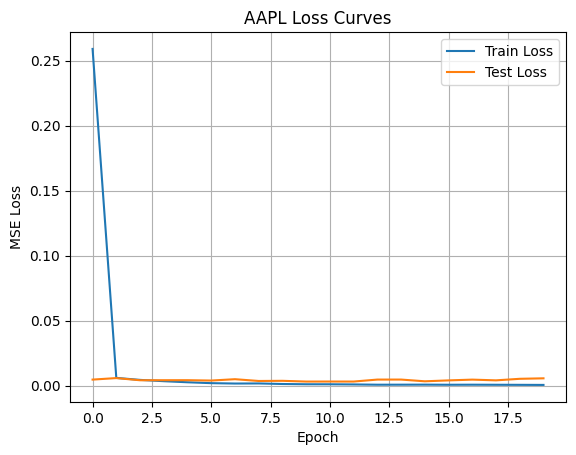

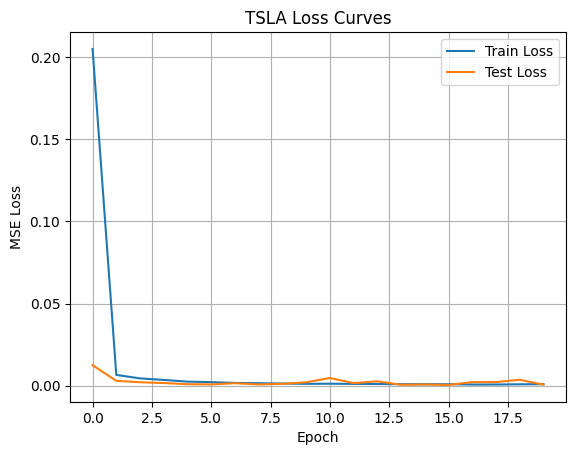

In [77]:
import matplotlib.pyplot as plt

# now we plot training curves to get some insight into how our models trained
def plot_losses(train_losses, test_losses, title="Loss Curves"):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(aapl_train_losses, aapl_test_losses, title="AAPL Loss Curves")
plot_losses(tsla_train_losses, tsla_test_losses, title="TSLA Loss Curves")

So when looking at our loss curves, we first look at AAPL's. We see a big initial drop and then the model starts to learn meaningful patterns. Train and test losses are both low and stable, which means little overfitting. Because the test loss is so close to the train loss, this suggests good generalization. So the transformer model likely learned to forecast AAPL Open prices pretty well and is not overfitting. Good news, which means we can move forward with it.

When we look at the TSLA loss curve, we see a very similar graph. In this case, we do also see the big drop, so a steep learning curve in the first epoch. We do see that train loss < test loss, but this is barely by any meaningful margin, so we don't conclude based on it. Test loss remains low and flat so it also is not overfitted and has fairly good generalization. Overall it is probably a bit noisier than AAPL but still very stable. Good enough for our purposes here, where we are mostly interested in the explanations we will be generating below!

# Prediction evaluation

So now that we have trained models that have not overfitted and generally have good generalization, we can move forward. We will look at what the model predicted, what the true value was and what the input sequence was that was used for the prediction. After we have a little bit of insight, we move on to create our explanations.

In [78]:
## AAPL
# get one batch from the AAPL test set
aapl_batch = next(iter(aapl_test_loader))
X_test_sample, y_test_sample = aapl_batch

# choose a single example from the batch
idx = 0
input_seq = X_test_sample[idx].unsqueeze(0)  # shape: (1, 30, 5)
true_value = y_test_sample[idx].item()

# make the model prediciton
model_aapl.eval()
with torch.no_grad():
    input_seq_device = input_seq.to(next(model_aapl.parameters()).device)
    prediction = model_aapl(input_seq_device).item()

# print and inspect (normalized values)
print(f"True Open Price (normalized):      {true_value:.4f}")
print(f"Predicted Open Price (normalized): {prediction:.4f}")

# print and inspect (real values in dollars)
inverse_input = np.zeros((1, 5))  # shape (1, features)
inverse_input[0, 0] = prediction
real_pred = scaler_AAPL.inverse_transform(inverse_input)[0, 0]

inverse_input[0, 0] = true_value
real_true = scaler_AAPL.inverse_transform(inverse_input)[0, 0]

print(f"True Open Price(real scale):       ${real_true:.2f}")
print(f"Predicted Open Price (real scale): ${real_pred:.2f}")

True Open Price (normalized):      0.6663
Predicted Open Price (normalized): 0.6752
True Open Price(real scale):       $178.71
Predicted Open Price (real scale): $180.82


# Generating Explanations

So now that our Transformer models can predict values, we want to understand them better. We will be creating explanation instances for Integrated Gradients (IG) and Layer-wise Relevance Propagation (LRP).

Because we are looking at how effective IG and LRP are at explaining these Time series predictions, we are going to generate 4 separate explanations:


1.   IG on AAPL prediction
2.   IG on TSLA prediction
3.   LRP on AAPL prediction
4.   LRP on TSLA prediction

We want to visualise and explain two metrics, which features where important and which time steps had the most influence.

## 1. Creating IG explanation

In [79]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import seaborn as sns

def explain_with_ig(model, input_seq, feature_names, title="Integrated Gradients Attribution"):
    device = next(model.parameters()).device
    model.eval()
    input_seq = input_seq.to(device)

    # define baseline (zeros)
    baseline = torch.zeros_like(input_seq)

    # define wrapper
    def model_forward(x):
        return model(x)

    # run IG
    ig = IntegratedGradients(model_forward)
    attributions, delta = ig.attribute(input_seq, baseline, target=None, return_convergence_delta=True)

    # convert for plotting
    attr = attributions.squeeze(0).detach().cpu().numpy()

    # plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(attr.T, xticklabels=range(1, attr.shape[0]+1), yticklabels=feature_names, cmap="coolwarm", center=0)
    plt.title(title)
    plt.xlabel("Time Step (Days Before Prediction)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return attributions, delta

## 1.1 AAPL

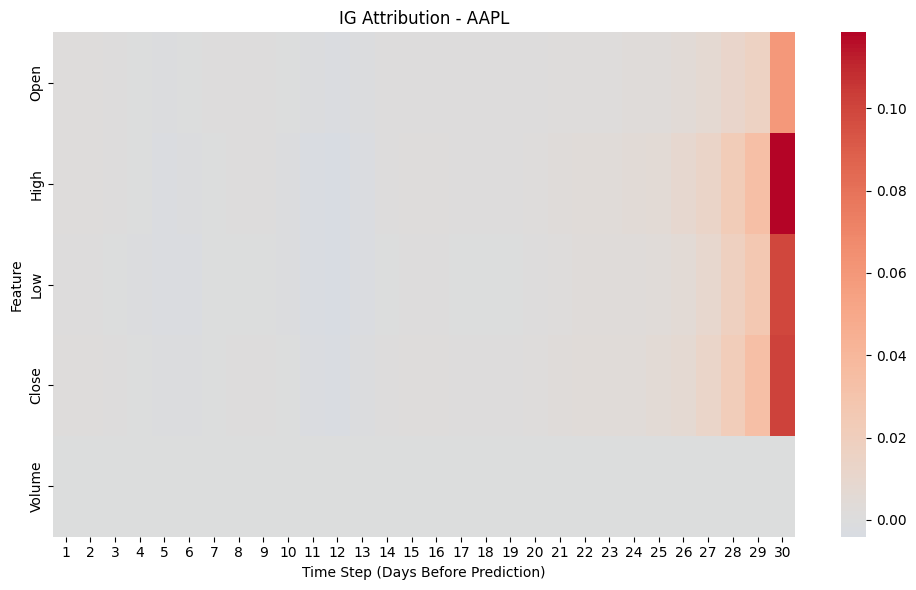

In [80]:
# get one example from AAPL test set
aapl_batch = next(iter(aapl_test_loader))
X_test_sample, y_test_sample = aapl_batch
input_seq = X_test_sample[0].unsqueeze(0)

# feature names in order
feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']

# explain AAPL
_ = explain_with_ig(model_aapl, input_seq, feature_names, title="IG Attribution - AAPL")

## 1.2 TSLA

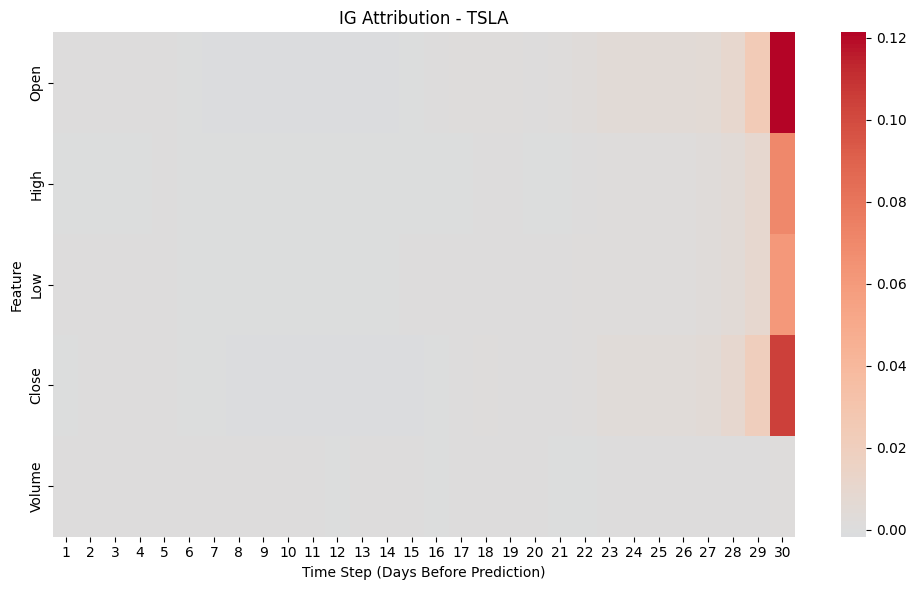

In [81]:
# get one example from TSLA test set
tsla_batch = next(iter(tsla_test_loader))
X_test_sample, y_test_sample = tsla_batch
input_seq = X_test_sample[0].unsqueeze(0)

# explain TSLA
_ = explain_with_ig(model_tsla, input_seq, feature_names, title="IG Attribution - TSLA")

# 2. Creating LRP Explanation

In [82]:
from captum.attr import DeepLift

def explain_with_lrp(model, input_seq, feature_names, title="Layer-wise Relevance Attribution (DeepLIFT as LRP approx)"):
    device = next(model.parameters()).device
    model.eval()
    input_seq = input_seq.to(device)

    # ensure gradient tracking
    input_seq.requires_grad_()

    # define baseline
    baseline = torch.zeros_like(input_seq)

    # apply DeepLIFT directly to the model
    lrp = DeepLift(model)
    attributions = lrp.attribute(input_seq, baseline)

    # convert for plotting
    attr = attributions.squeeze(0).detach().cpu().numpy()

    # plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(attr.T, xticklabels=range(1, attr.shape[0]+1), yticklabels=feature_names, cmap="coolwarm", center=0)
    plt.title(title)
    plt.xlabel("Time Step (Days Before Prediction)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return attributions

## 2.1 AAPL

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


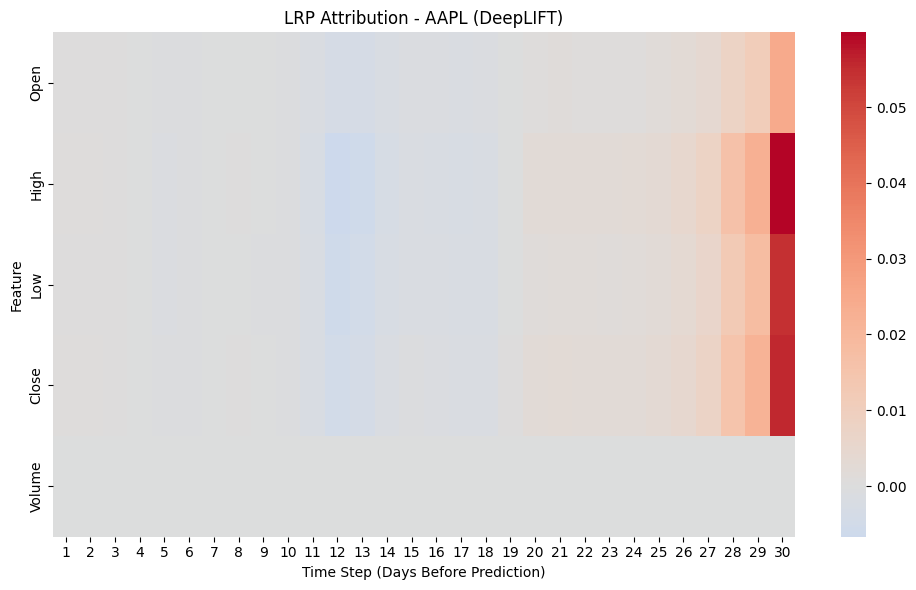

In [83]:
# AAPL test example
aapl_batch = next(iter(aapl_test_loader))
X_test_sample, y_test_sample = aapl_batch
input_seq = X_test_sample[0].unsqueeze(0)

_ = explain_with_lrp(model_aapl, input_seq, feature_names, title="LRP Attribution - AAPL (DeepLIFT)")

## 2.2 TSLA

/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


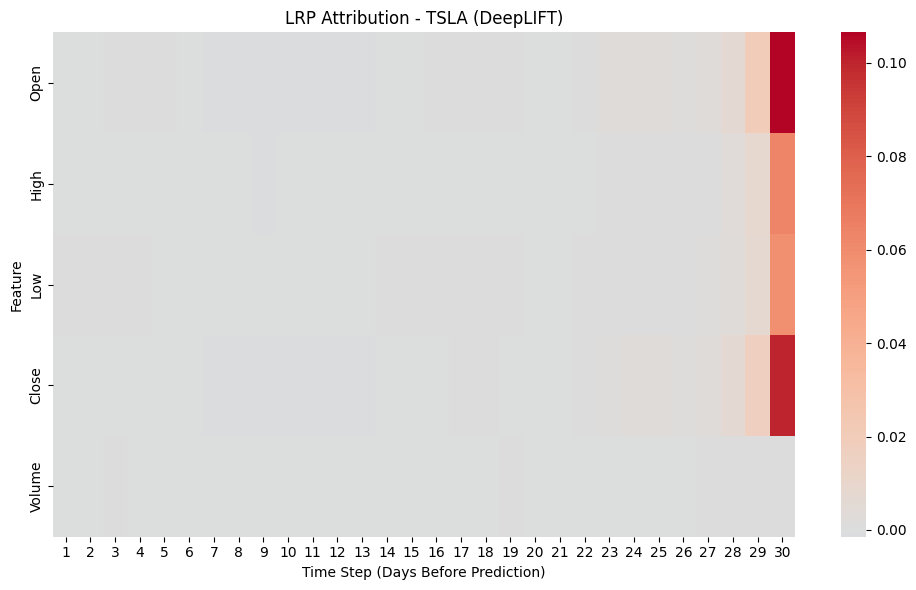

In [84]:
# TSLA test example
tsla_batch = next(iter(tsla_test_loader))
X_test_sample, y_test_sample = tsla_batch
input_seq = X_test_sample[0].unsqueeze(0)

_ = explain_with_lrp(model_tsla, input_seq, feature_names, title="LRP Attribution - TSLA (DeepLIFT)")

# Analysis of the explanations

In a more quantative way we want to want to know some more things. We want to extract which features mattered most overall and which time steps were the most influential. We can write some code to get some insight into this.

In [85]:
import numpy as np
import pandas as pd

# define analysis function
def analyze_attributions(attributions, feature_names, top_k=5):
    """
    attributions: torch.Tensor of shape (1, seq_len, num_features)
    feature_names: list of feature names
    """

    attr_np = attributions.squeeze(0).detach().cpu().numpy()  # (seq_len, num_features)

    # Absolute value to get magnitude of importance
    abs_attr = np.abs(attr_np)

    # ---- Feature importance ----
    feature_importance = abs_attr.sum(axis=0)  # sum across time steps
    feature_df = pd.DataFrame({
        'Feature': feature_names,
        'Total Importance': feature_importance
    }).sort_values(by='Total Importance', ascending=False)

    print("\nTop Features by Total Importance:")
    print(feature_df.head(top_k).to_string(index=False))

    # ---- Time step importance ----
    timestep_importance = abs_attr.sum(axis=1)  # sum across features
    timestep_df = pd.DataFrame({
        'Time Step (from past)': list(range(1, len(timestep_importance)+1)),
        'Total Importance': timestep_importance
    }).sort_values(by='Total Importance', ascending=False)

    print("\nTop Time Steps by Total Importance:")
    print(timestep_df.head(top_k).to_string(index=False))

    return feature_df, timestep_df


IG - AAPL Attribution Analysis


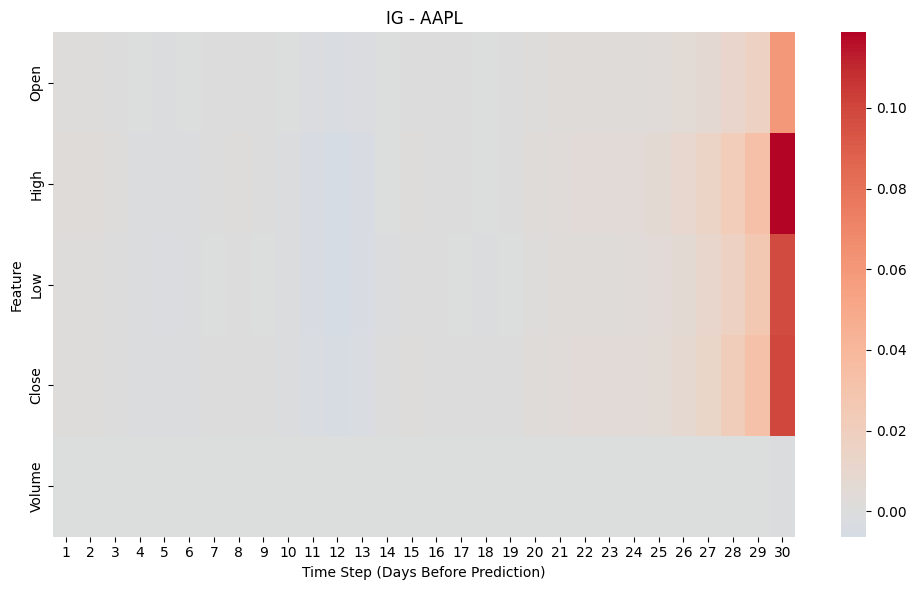


Top Features by Total Importance:
Feature  Total Importance
   High          0.252779
  Close          0.222444
    Low          0.200124

Top Time Steps by Total Importance:
 Time Step (from past)  Total Importance
                    30          0.376858
                    29          0.108405
                    28          0.071343

LRP - AAPL Attribution Analysis


/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


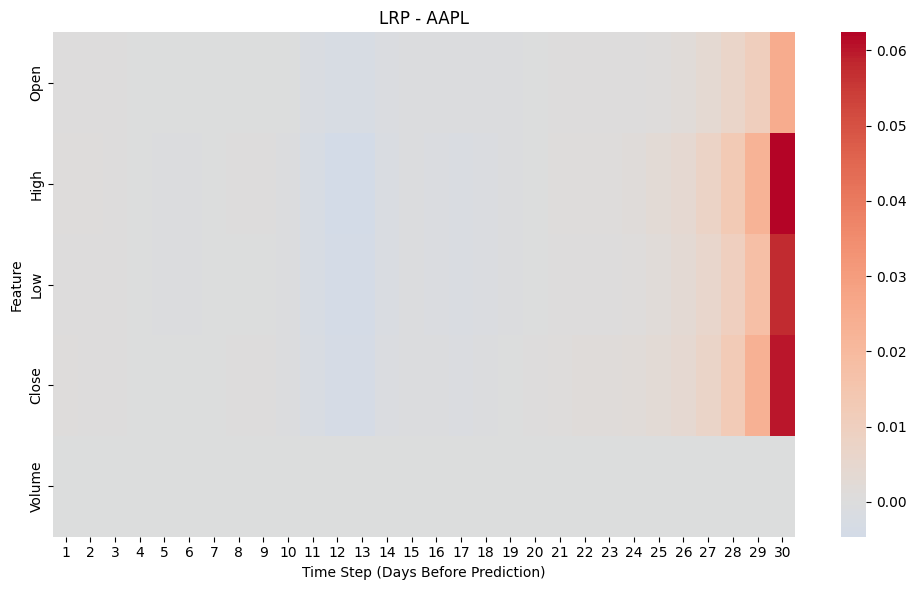


Top Features by Total Importance:
Feature  Total Importance
   High          0.140350
  Close          0.131935
    Low          0.119421

Top Time Steps by Total Importance:
 Time Step (from past)  Total Importance
                    30          0.206026
                    29          0.074766
                    28          0.042139

IG - TSLA Attribution Analysis


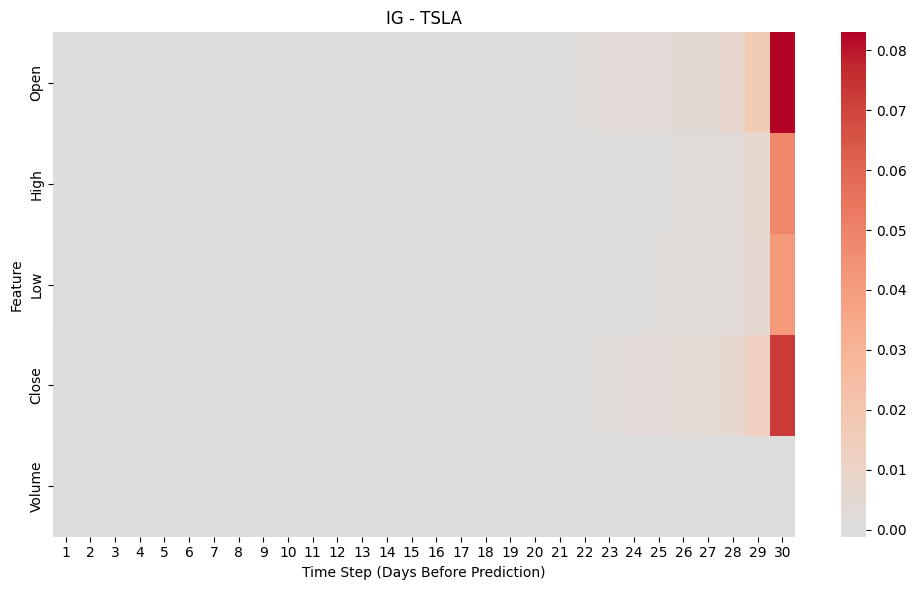


Top Features by Total Importance:
Feature  Total Importance
   Open          0.143358
  Close          0.122339
   High          0.071590

Top Time Steps by Total Importance:
 Time Step (from past)  Total Importance
                    30          0.245786
                    29          0.042137
                    28          0.021498

LRP - TSLA Attribution Analysis


/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


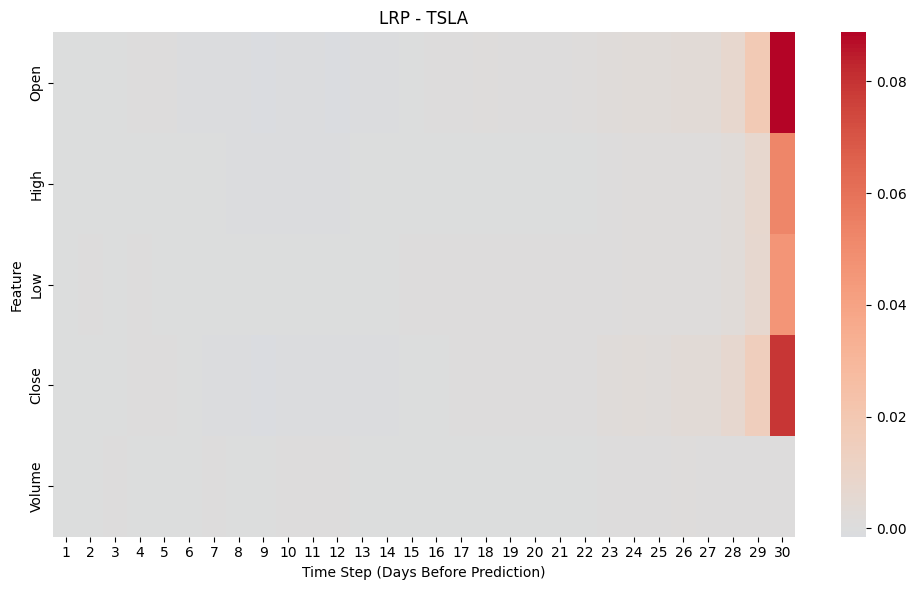


Top Features by Total Importance:
Feature  Total Importance
   Open          0.145316
  Close          0.126049
   High          0.073906

Top Time Steps by Total Importance:
 Time Step (from past)  Total Importance
                    30          0.267482
                    29          0.047604
                    28          0.020583


In [86]:
# AAPL
print("\nIG - AAPL Attribution Analysis")
ig_aapl, _ = explain_with_ig(model_aapl, input_seq_aapl, feature_names, title="IG - AAPL")
ig_aapl_feats, ig_aapl_time = analyze_attributions(ig_aapl, feature_names, top_k=3)

print("\nLRP - AAPL Attribution Analysis")
lrp_aapl = explain_with_lrp(model_aapl, input_seq_aapl, feature_names, title="LRP - AAPL")
lrp_aapl_feats, lrp_aapl_time = analyze_attributions(lrp_aapl, feature_names, top_k=3)

# TSLA
print("\nIG - TSLA Attribution Analysis")
ig_tsla, _ = explain_with_ig(model_tsla, input_seq_tsla, feature_names, title="IG - TSLA")
ig_tsla_feats, ig_tsla_time = analyze_attributions(ig_tsla, feature_names, top_k=3)

print("\nLRP - TSLA Attribution Analysis")
lrp_tsla = explain_with_lrp(model_tsla, input_seq_tsla, feature_names, title="LRP - TSLA")
lrp_tsla_feats, lrp_tsla_time = analyze_attributions(lrp_tsla, feature_names, top_k=3)

Then we want to create some bar charts to make it a bit easier to understand just by looking at it.

In [87]:
# define function for feature importance bar plots
def plot_feature_importance(ig_df, lrp_df, title_prefix="AAPL"):
    top_ig = ig_df.set_index("Feature").sort_values("Total Importance", ascending=False)
    top_lrp = lrp_df.set_index("Feature").sort_values("Total Importance", ascending=False)

    # Align features
    all_features = list(top_ig.index.union(top_lrp.index))
    ig_vals = top_ig.reindex(all_features).fillna(0)["Total Importance"]
    lrp_vals = top_lrp.reindex(all_features).fillna(0)["Total Importance"]

    # Plot
    x = np.arange(len(all_features))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, ig_vals, width, label='IG')
    plt.bar(x + width/2, lrp_vals, width, label='LRP')
    plt.xticks(ticks=x, labels=all_features)
    plt.ylabel("Total Importance")
    plt.title(f"Top Feature Importance - {title_prefix}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [88]:
# define function for time step importance bar plots
def plot_timestep_importance(ig_df, lrp_df, title_prefix="AAPL"):
    # Sort by time step order
    ig_sorted = ig_df.sort_values("Time Step (from past)")
    lrp_sorted = lrp_df.sort_values("Time Step (from past)")

    x = ig_sorted["Time Step (from past)"]
    ig_vals = ig_sorted["Total Importance"]
    lrp_vals = lrp_sorted["Total Importance"]

    plt.figure(figsize=(10, 4))
    plt.plot(x, ig_vals, marker='o', label='IG')
    plt.plot(x, lrp_vals, marker='s', label='LRP')
    plt.xlabel("Time Step (1 = oldest, 30 = most recent)")
    plt.ylabel("Total Importance")
    plt.title(f"Time Step Importance - {title_prefix}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

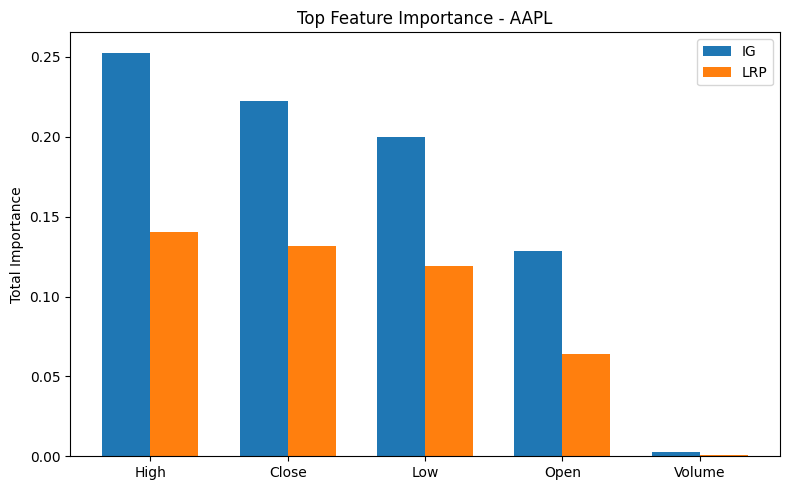

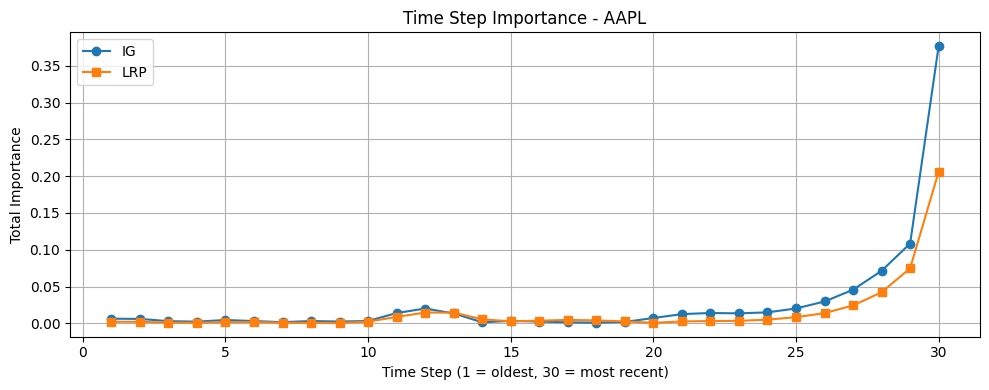

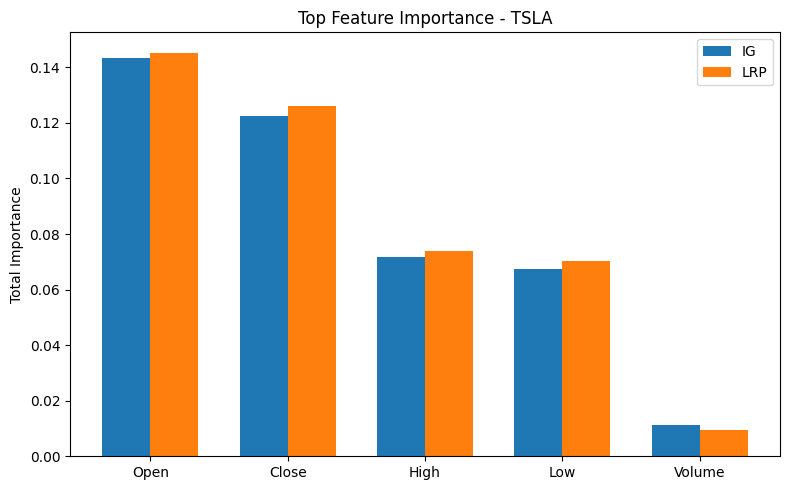

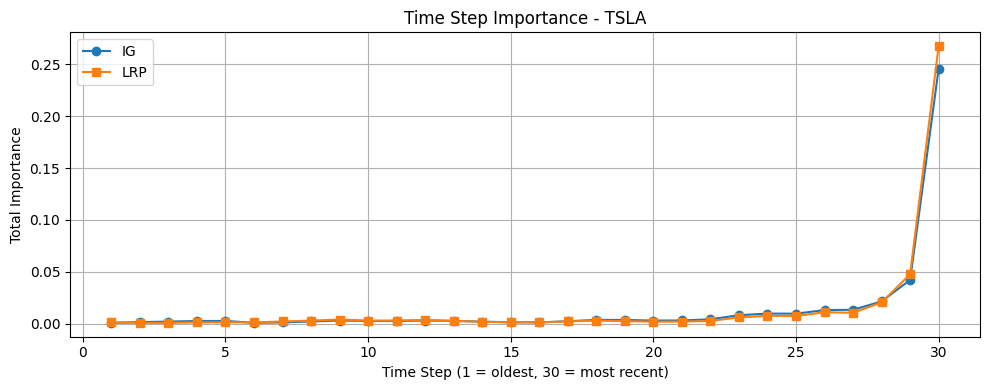

In [89]:
# AAPL
plot_feature_importance(ig_aapl_feats, lrp_aapl_feats, title_prefix="AAPL")
plot_timestep_importance(ig_aapl_time, lrp_aapl_time, title_prefix="AAPL")

# TSLA
plot_feature_importance(ig_tsla_feats, lrp_tsla_feats, title_prefix="TSLA")
plot_timestep_importance(ig_tsla_time, lrp_tsla_time, title_prefix="TSLA")

# Results

So, now that we have completed the aim of our project, we want to look at our reseach question again. We will aim to answer this in the results section of the report, where you can find more in depth analysis on this. The figures were created here and will be shown in the report as well.